# **SAT Scores of NYC High Schools** #

<ins>Question:</ins> Are the SAT Scores a fair representation of academic performance across high schools in New York City?

<ins>Results:</ins>

![FinalResult](./FinalPlot.png)

<ins>Conclusion:</ins>\
\
**The analysis suggests that the SAT may not be a completely fair test for all students in NYC.\
Substantial differences in  SAT scores across different racial groups and gender indicate potential biases in the test.\
Further investigation and potential adjustments to the SAT may be necessary to ensure fairness for all demographic groups.**

---

Background:\
\
The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.


---

Motivation:\
\
New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

---

Data Description:\
\
New York City has published data on student SAT scores by high school, along with additional demographic datasets.

* [SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) by school - SAT scores for each high school in New York City

* [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City

* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school

* [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)

* [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

---

## Data and Lib Import ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


In [2]:
# List of files to load
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Load the data into a dictionary
data = {}
for file in data_files :
    filepath = "Data/" + file
    dataframe = pd.read_csv(filepath)
    key_name = file.replace('.csv', '')
    data[key_name]=dataframe


# Read the survey data
all_survey = pd.read_csv('Data/survey_all.txt', delimiter = '\t', encoding = "windows-1252")
d75_survey = pd.read_csv('Data/survey_d75.txt', delimiter = '\t', encoding = "windows-1252")
# Combine the survey data
survey = pd.concat([all_survey,d75_survey], axis=0)


## Data Exploration and Cleaning ##

In [3]:
# Print the first 5 rows of each data set
for i in data :
    print(data[i].head(5))


      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

In [4]:
# Print the first 5 rows of the survey data
print(survey.head(5))

      dbn    bn                      schoolname  d75 studentssurveyed  \
0  01M015  M015       P.S. 015 Roberto Clemente    0               No   
1  01M019  M019             P.S. 019 Asher Levy    0               No   
2  01M020  M020            P.S. 020 Anna Silver    0               No   
3  01M034  M034  P.S. 034 Franklin D. Roosevelt    0              Yes   
4  01M063  M063       P.S. 063 William McKinley    0               No   

   highschool                  schooltype  rr_s  rr_t  rr_p  ...  s_q14_2  \
0         0.0           Elementary School   NaN    88    60  ...      NaN   
1         0.0           Elementary School   NaN   100    60  ...      NaN   
2         0.0           Elementary School   NaN    88    73  ...      NaN   
3         0.0  Elementary / Middle School  89.0    73    50  ...      NaN   
4         0.0           Elementary School   NaN   100    60  ...      NaN   

   s_q14_3  s_q14_4  s_q14_5  s_q14_6  s_q14_7  s_q14_8  s_q14_9  s_q14_10  \
0      NaN      NaN 

### Cleaning Datasets ###

A few of the datasets need to be cleaned before they can be combined.
Specifically, we want to have a 'DNB' column in all datasets to be able to combine them.


#### Class Size Data ####

In [5]:
# Add a DBN column to the class_size data set
def format_number(number):
    # Convert the number to a string
    number_str = str(number)
    # Check the length of the string
    if len(number_str) == 2:
        return number_str
    elif len(number_str) == 1:
        # Add a 0 to the front of the string if it is one digit long
        return number_str.zfill(2)

data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(format_number)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

# Condense the class_size data set so that each DBN is unique
# This will enable us to combine the data sets
# we're only concerned with grades 9 through 12 and Gen Ed program types

class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

# CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) 
# seem to pertain to different kinds of classes
# We want our class size data to include every single class a school offers -- not just a subset of them
class_size = class_size.groupby('DBN').agg("mean", numeric_only=True)
class_size.reset_index(inplace=True)

# Assign the class_size data to the data dictionary
data['class_size'] = class_size



#### High School Directory Data ####

In [6]:

# Rename the dbn column in the hs_directory data set
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

# parse the latitude and longitude coordinates for each school 
# This enables us to map the schools and uncover any geographic patterns in the data
import re

def find_lat(loc):
    coords = re.findall("\(.+\)", loc)
    lat = coords[0].split(",")[0].replace('(','').replace(')','')
    return lat

def find_lon(loc):
    coords = re.findall("\(.+\)", loc)
    lat = coords[0].split(",")[1].replace('(','').replace(')','')
    return lat

data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors = "coerce")
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors = "coerce")



#### SAT Results Data ####

In [7]:

# Convert the columns in the survey data set to numeric
data['sat_results']['SAT Math Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Math Avg. Score'], errors = "coerce")
data['sat_results']['SAT Critical Reading Avg. Score'] =pd.to_numeric(data['sat_results']['SAT Critical Reading Avg. Score'], errors = "coerce")
data['sat_results']['SAT Writing Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Writing Avg. Score'], errors = "coerce")
# Add the SAT scores together to get the total SAT score
data['sat_results']['sat_score'] = data['sat_results']['SAT Math Avg. Score'] + data['sat_results']['SAT Critical Reading Avg. Score'] + data['sat_results']['SAT Writing Avg. Score'] 



#### Demographics Data ####

In [8]:

# Condense the demographics data set so that each DBN is unique
# the most recent schoolyear is 20112012
demographics = data['demographics']
demographics = demographics[demographics['schoolyear'] == 20112012]

data['demographics'] = demographics


#### Graduation Data ####

In [9]:
## Graduation Data

# Condense the graduation data set so that each DBN is unique
# This will enable us to combine the data sets
# most recent Cohort column is 2006
graduation = data['graduation']
graduation = graduation[graduation['Cohort'] == '2006']
graduation = graduation[graduation['Demographic'] == 'Total Cohort']
# Assign the graduation data to the data dictionary
data['graduation'] = graduation


#### AP Scores Data ####

In [10]:

# Convert the Advanced Placement (AP) test scores to numeric
ap_2010 = data['ap_2010']
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    ap_2010[col] = pd.to_numeric(ap_2010[col], errors="coerce")

data['ap_2010'] = ap_2010


#### Survey Data ####

In [11]:

# Clean the survey data
survey = survey.copy()
survey['DBN'] = survey['dbn']
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
# Assign the survey data to the data dictionary
data['survey'] = survey



### Combining Datasets ###

In [12]:
# Start with the sat_results data set
combined = data["sat_results"]
# Merge the ap_2010 and graduation data sets
to_merge_inner = ["ap_2010", "graduation"]
for dataset in to_merge_inner:
    combined = combined.merge(data[dataset], on="DBN", how="left")
# Merge the remaining data sets
to_merge_left = ["class_size", "demographics", "survey", "hs_directory"]
for dataset in to_merge_left:
    combined = combined.merge(data[dataset], on="DBN", how="inner")



### Impute Missing Values ###

In [13]:

# impute the missing values with the means of their respective columns, 
means = combined.mean(numeric_only=True)
combined = combined.fillna(means)

# Fill in any remaining missing values in the combined data set with 0
combined = combined.infer_objects(copy=False).fillna(0)

# Add a school district column for mapping
def get_first_two_chars(dbn):
    return dbn[0:2]
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)


/var/folders/bz/z0p5vwlj7_728l4_4p7pz_yh0000gn/T/ipykernel_97539/716649199.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)


## Data Analysis ##

### Correlations ###

In [14]:
# Find correlations between the SAT scores and other columns in the combined data set
correlations = combined.corr(numeric_only=True)
correlations = correlations["sat_score"]
print(correlations)


SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


In [15]:
# show the top 10 correlations in absolute value    
print(correlations.abs().sort_values(ascending=False).head(25))

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
frl_percent                             0.722225
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
sped_percent                            0.448170
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
ell_percent                             0.398750
hispanic_per                            0.396985
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE  

`total_enrollment` has a positive correlation with sat_score.\
This is surprising because we'd expect smaller schools where students receive more attention to have higher scores.\
However, it looks like the opposite is true -- larger schools tend to do better on the SAT.\
\
Other columns that are proxies for enrollment correlate similarly. These include `total_students`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`.\
\
Both the percentage of females (`female_per`) and number of females (`female_num`) at a school correlate positively with SAT score, whereas the percentage of males (`male_per`) and the number of males (`male_num`) correlate negatively.\
This could indicate that women do better on the SAT than men.\
\
Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with sat_score.\
Student ratings of school academic standards (`aca_s_11`) correlate with sat_score, but this does not hold for ratings from teachers and parents (`aca_p_11` and `aca_t_11`).\
\
There is significant racial inequality in SAT scores (`white_per`, `asian_per`, `black_per`, `hispanic_per`).\
\
The percentage of students eligible for free or reduced school lunch based on household income (`frl_percent`) has a strong negative correlation with SAT scores.



### Enrollment vs. SAT Scores ###

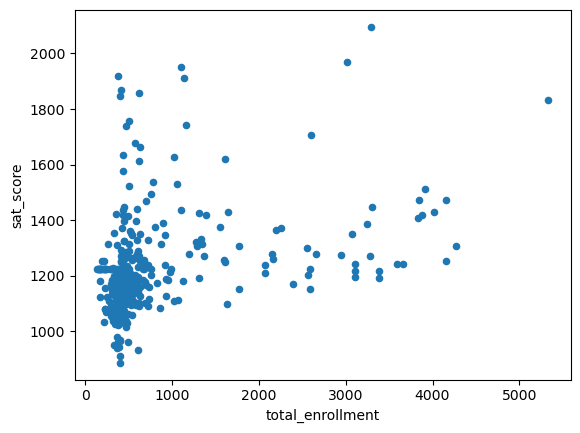

In [16]:
# Plotting the relationship between total_enrollment and sat_score
combined.plot.scatter(x='total_enrollment', y='sat_score')
plt.show()


There is a cluster of schools with low total enrollment and low SAT scores,
and several instances of schools with high total enrollment and high SAT scores.

In [17]:
# Investigate the schools with low total enrollment and low SAT scores
low_enrollment = combined[combined['total_enrollment'] < 1000]
low_enrollment = low_enrollment[low_enrollment['sat_score'] < 1000]
print(low_enrollment['School Name'])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


The schools listed above appear to primarily be vocational schools.


**But what about the other factors influencing SAT scores?**

### Survey Correlations ###

<Axes: >

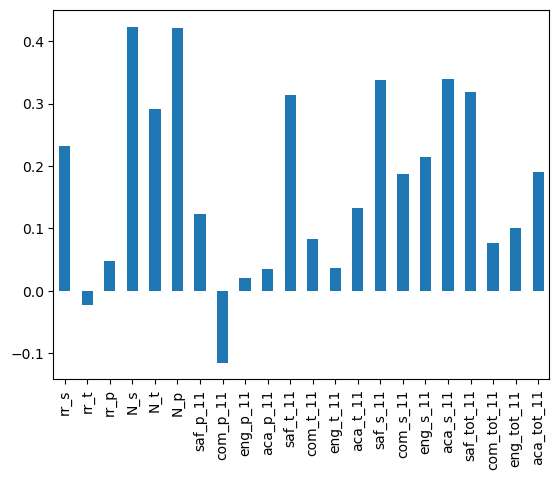

In [18]:

%matplotlib inline
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
# Plotting the correlations between the survey fields and the SAT scores
combined.corr(numeric_only=True)["sat_score"][survey_fields].plot.bar()

`saf_t_11` and `saf_s_11`, which measure how teachers and students perceive safety at school, correlated highly with `sat_score`. This makes sense because difficult to teach or learn in an unsafe environment.\
\
`N_s`, `Ns_t`and `N_p`are proxies for the number of participants, hence also the enrollment number, and therefore also correlate highly with `sat_score`.\
\
`rr_s`, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

Lastly, while `aca_s_11`, which indicates how the student perceives academic standards, is strongly correlated with `sat_score`, both `aca_t_11` (how teachers perceive academic standards) and `aca_p_11` (how parents perceive academic standards) are not.

**Subsequently it might be worth it to explore the some of the survey fields in more detail.**

#### Safety vs. SAT Scores ####

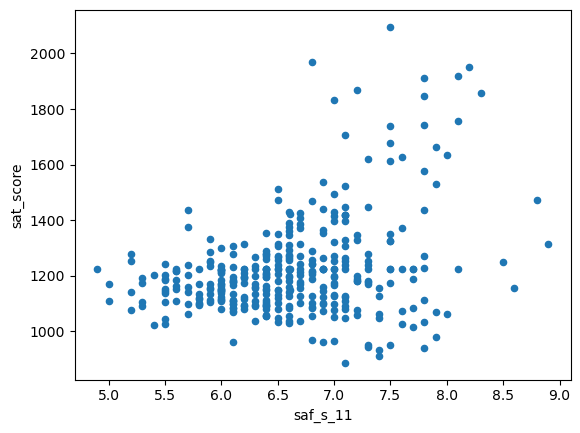

In [19]:
# Scatter plot of the saf_s_11 column vs. the sat_score in combined
combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.show()


The correlation between SAT scores and perceived student safety isn't very strong.\
There are a few schools with extremely high SAT scores and high safety scores, and a few schools with low safety scores and low SAT scores.\
No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

In [20]:
# Compute the average student safety score for each borough
boros = combined.groupby("boro").agg('mean', numeric_only=True)["saf_s_11"]
print(boros)


boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


It looks like *Manhattan* and *Queens* tend to have higher safety scores, whereas **Brooklyn** has low safety scores.

While some of the survey fields might be biased by the people filling out the surveys, there are additional correlations that might be worth to explore.

### Race vs. SAT Score ###

There are a few columns that indicate the percentage of each race at a given school:

* `white_per`
* `asian_per`
* `black_per`
* `hispanic_per`

<Axes: >

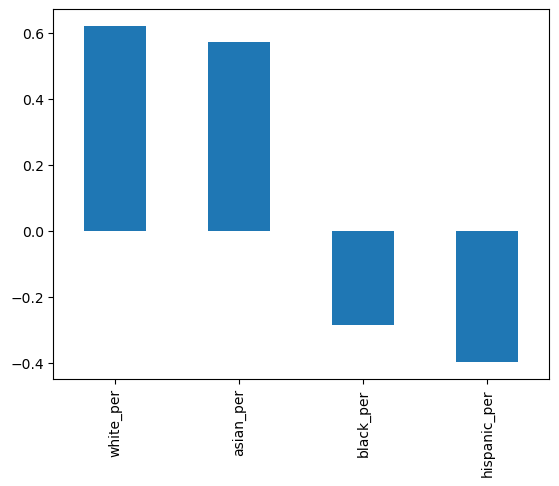

In [21]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
# Plotting the correlations between race fields and the SAT scores
combined.corr(numeric_only=True)["sat_score"][race_fields].plot.bar()


It looks like a higher percentage of white or Asian students at a school correlates positively with SAT scores, whereas a higher percentage of black or Hispanic students correlates negatively with SAT score.\
\
This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or Hispanic students.

<Axes: xlabel='hispanic_per', ylabel='sat_score'>

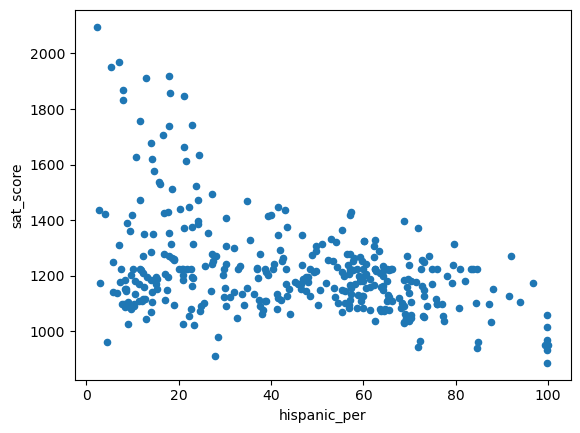

In [22]:
# correlation plot for Hispanic students
combined.plot.scatter("hispanic_per", "sat_score")

<Axes: xlabel='black_per', ylabel='sat_score'>

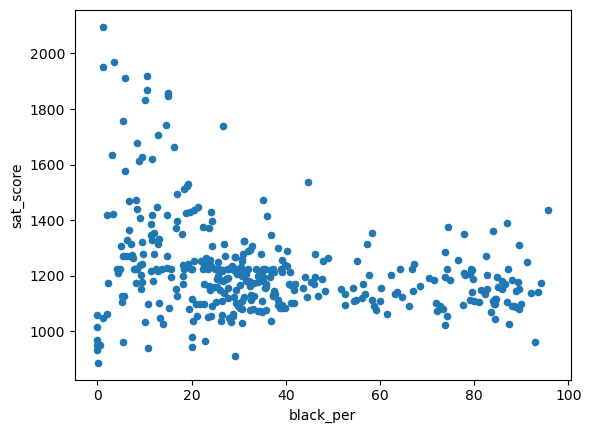

In [23]:
# correlation plot for Black students
combined.plot.scatter("black_per", "sat_score")

In [24]:
# the schools that have a proportion of hispanic or black students that is higher than 95%
print(combined[(combined["hispanic_per"] > 95) | (combined["black_per"] > 95)]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores.

In [25]:
# Explore schools with less than 10% Hispanic or Black students and SAT scores over 1800
print(combined[(combined["sat_score"] > 1800) & ((combined["hispanic_per"] < 10) | (combined["black_per"] < 10))]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding and only admit students who pass an entrance exam.\
\
This doesn't explain the low `hispanic_per` or `black_per`, but it does explain why their students tend to do better on the SAT — they are students from all over New York City who did well on a standardized test.

### Gender vs. SAT Scores ###

There are two columns that indicate the percentage of each gender at a school:

* `male_per`
* `female_per`

<Axes: >

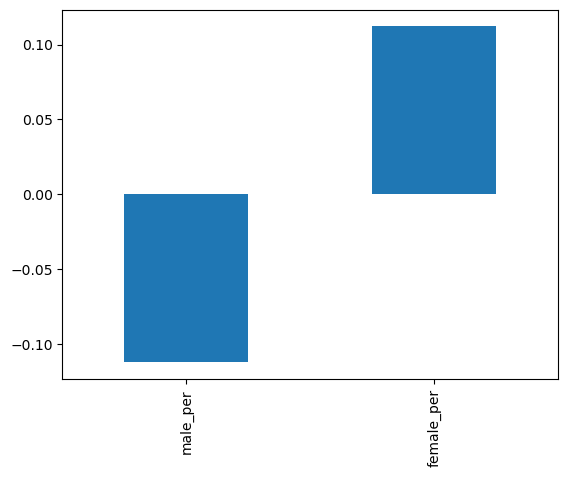

In [26]:
gender_fields = ["male_per", "female_per"]
# correlation plot of SAT vs. Gender  
combined.corr(numeric_only=True)["sat_score"][gender_fields].plot.bar()

A high percentage of females at a school positively correlates with SAT scores, whereas a high percentage of males at a school negatively correlates with SAT scores. Neither correlation is particularily strong.

<Axes: xlabel='female_per', ylabel='sat_score'>

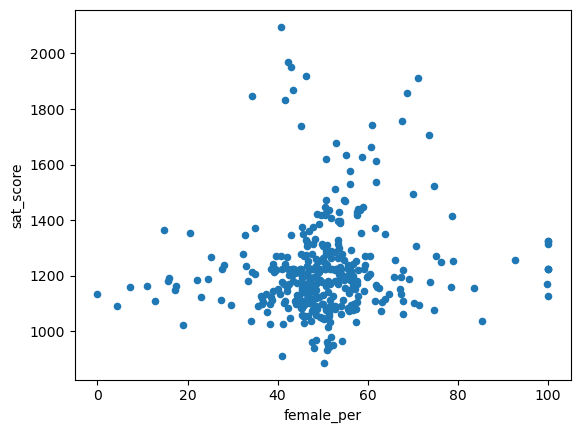

In [27]:
# scatter plot of just female vs. SAT
combined.plot.scatter("female_per", "sat_score")

Based on the scatter plot, there doesn't seem to be any real correlation between `sat_score` and `female_per`.\
\
However, there is a cluster of schools with a high percentage of females (60 to 80) and high SAT scores.

In [28]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


**These schools appear to be very selective liberal arts schools that have high academic standards.**

### AP Exam Scores vs. SAT Scores ###

High school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

As a result, the number of students at a school who took AP exams might be highly correlated with the school's SAT scores.

/var/folders/bz/z0p5vwlj7_728l4_4p7pz_yh0000gn/T/ipykernel_97539/2699950379.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]


<Axes: xlabel='ap_per', ylabel='sat_score'>

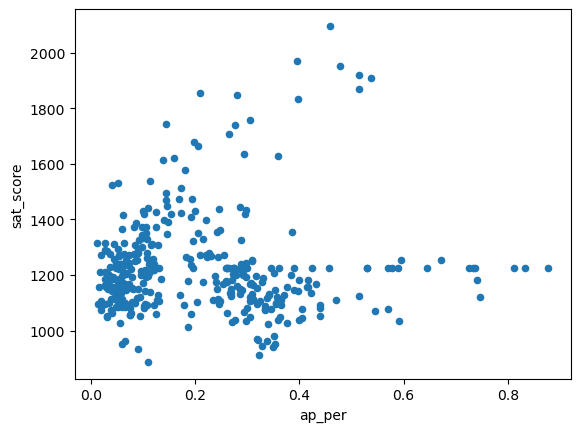

In [29]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined = combined.copy()
combined.plot.scatter(x='ap_per', y='sat_score')

While it is not a strong correlation, there is a relationship between the percentage of students in a school who take the AP exam and their average SAT scores.

### Final Plot ###

In [30]:

# Calculate correlations
race_corr = combined.corr(numeric_only=True)["sat_score"][race_fields]
gender_corr = combined.corr(numeric_only=True)["sat_score"][gender_fields]

# Concatenate results
combined_corr = pd.concat([race_corr, gender_corr])

# Reset index for plotting
combined_corr = combined_corr.reset_index()
combined_corr.columns = ['Field', 'Correlation']



/var/folders/bz/z0p5vwlj7_728l4_4p7pz_yh0000gn/T/ipykernel_97539/1245360360.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Correlation', y='Field', data=combined_corr, palette=colors)


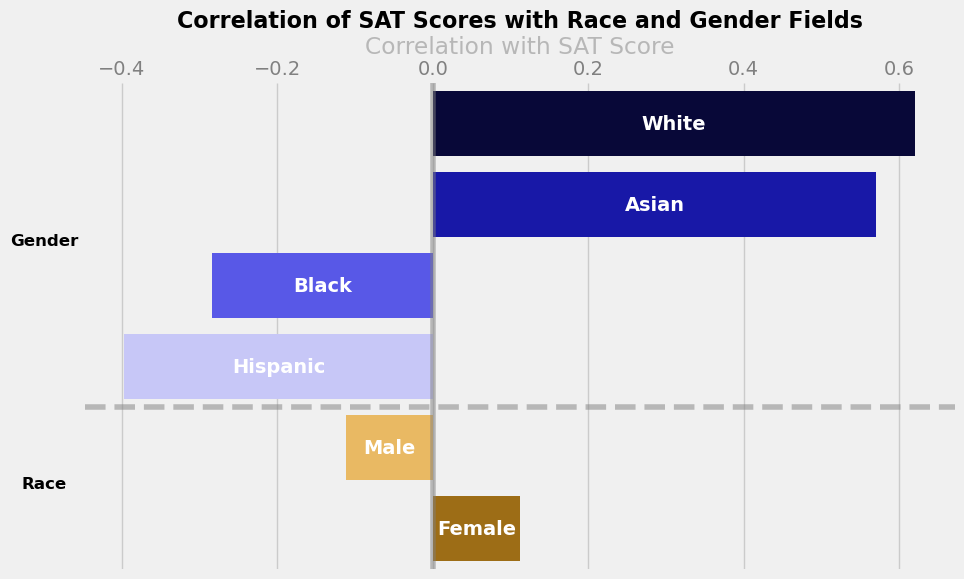

In [31]:

# Mapping for labels
label_mapping = {
    'white_per': 'White',
    'asian_per': 'Asian',
    'black_per': 'Black',
    'hispanic_per': 'Hispanic',
    'male_per': 'Male',
    'female_per': 'Female'
}

# Create a combined row chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 6))
colors = ['#000040', '#0000bf', '#4040ff', '#bfbfff', '#ffc04d', '#b37300']  # Custom colors
ax = sns.barplot(x='Correlation', y='Field', data=combined_corr, palette=colors)

# Customize the plot
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.axvline(x=0.0, color='grey', alpha=0.5)
plt.title('Correlation of SAT Scores with Race and Gender Fields', fontsize=16, fontweight='bold')
plt.xlabel('Correlation with SAT Score', color='grey', alpha=0.5)
ax.set_ylabel('')  # Remove y-axis title
ax.set_yticklabels([])  # Remove y-axis labels on the left side
ax.tick_params(axis='y', which='both', length=0)  # Remove y-axis ticks
ax.tick_params(axis='x', colors='grey')  # Make x-axis ticks grey and alpha 0.5
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Set y-axis labels just outside the bars and change font color to black and bold
for index, value in enumerate(combined_corr['Correlation']):
    field = combined_corr["Field"][index]
    label = label_mapping.get(field, field)
    x_pos = value - (value / 2) # Adjust the x position as needed
    ax.text(x_pos, index, label, color='white', va='center', ha = 'center', fontweight='bold')


# Add a dotted horizontal line below the top 4 bars
plt.axhline(y=3.5, color='grey', linestyle='--', alpha=0.5)

# Add group annotations
plt.text(-0.5, 4.5, 'Race', fontsize=12, color='black', ha='center', fontweight='bold')
plt.text(-0.5, 1.5, 'Gender', fontsize=12, color='black', ha='center', fontweight='bold')

plt.show()